# Background Detail Real-Valued - Story 2

This notebook assesses inter-annotator agreement for the background detail/information amount score. 
It imports JSON files to perform a number of statistical tests to assess inter-annotator agreement. 

##### Imports and packages

In [1]:
# Imports and Packages:

import json # json library
import os # for list directories 

from collections import Counter # counter library
import re # regex

import numpy as np 
import math
import matplotlib.pyplot as plt

import itertools
from itertools import permutations # library to print permutations
from itertools import combinations # library to print combinations

import sklearn # sklearn for inter-annotation kappa scores
from sklearn.metrics import cohen_kappa_score
import statsmodels
from statsmodels.stats.inter_rater import fleiss_kappa

import krippendorff #import for Fleiss Kappa inter-annotator agreement for more than 2 annotators

import scipy.stats
from scipy.stats import mode 
from scipy.stats import zscore # normalise data
from scipy.stats import mannwhitneyu # for Mann-Whitney U test
from scipy.stats import ttest_ind # independent t-test
from scipy.stats import spearmanr # spearmans rank
from scipy.stats import pearsonr # pearson's r


##### Import JSON data

In [2]:
# Import JSON data from Prolific Study

path_to_jsonFiles = "Annotations_Prolific/Background_Detail_RealValue_Story2/Processed_Data" # This is the folder with the json data files
corpus_story2 = {} # init a dict to hold each json data file
participantNum = 1 # init a participant num counter

for file in sorted(os.listdir(path_to_jsonFiles)):
    if file.endswith('.json'): # check that the file has a json extension (to circumvent hidden .DS_store files)
        full_file_name = "%s/%s" % (path_to_jsonFiles, file)
        with open(full_file_name, 'r') as fi:
            storyName = "participant" + str(participantNum)
            story_data = json.load(fi)
            corpus_story2[storyName] = story_data
        participantNum += 1
    
# all_stories holds all the json data files, with key "storyN" and value is the read in json file



In [3]:
#corpus_story2["participant1"]

##### Get annotator pair combinations as pairs of names in a list

In [4]:
# Combinations of annotators:
# Function to get the combinations of all participants

def get_combinations_of_annotators(all_annotation_data):
    """
    Takes: a dict containing all annotation data - this is the input of reading in all json files,
            as is done above.
    Returns: a list of tuples containing pairs of strings that indicate annotators. In other words, a list of 
            annotator pairs.
    """
    annotators = [] # init a list to store annotators
    annotator_pairs = [] # init a list to store all combination pairs
    
    for annotator, annotation_data in all_annotation_data.items():
        annotators.append(annotator)
     
    combs = itertools.combinations(annotators, 2) # get annotator combinations in sets of two
    
    for ann in list(combs):
        annotator_pairs.append(ann)
    
    return annotator_pairs


In [5]:
combinations_all_participants_story2 = get_combinations_of_annotators(corpus_story2)

In [6]:
# get a list of all values per participant

background_values = {}

for participant, story_info in corpus_story2.items():
    values = [] # init values list
    for page, page_info in story_info.items():
        for panel, panel_info in page_info.items():
            background_info = panel_info["background/setting"]
            value = float(background_info["information_amount"])
            values.append(value)
    
    background_values[participant] = values

In [ ]:
#background_values

##### Store the annotation values per annotator in a dictionary and list of lists for easier analysis

In [7]:
# put all sets of background values into a list of lists

list_of_lists_of_all_participant_values = []
for participant, values_list in background_values.items():
    #print(participant)
    #print(values_list)
    list_of_lists_of_all_participant_values.append(values_list)
    
print(len(list_of_lists_of_all_participant_values))


10


### Krippendorff's Alpha

##### Function to calculate Krippendorff's Alpha

In [11]:
# Krippendorff's Alpha - Inter-rater agreement measure

# Code from https://github.com/grrrr/krippendorff-alpha/blob/master/krippendorff_alpha.py

def nominal_metric(a, b):
    return a != b

def interval_metric(a, b):
    return (a-b)**2

def ratio_metric(a, b):
    return ((a-b)/(a+b))**2

def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Python implementation of Krippendorff's alpha -- inter-rater reliability
    (c)2011-17 Thomas Grill (http://grrrr.org)
    Python version >= 2.4 required

    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to 
    coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.



##### Krippendorff's Alpha result for all-against-all annotators, using the above function 

In [12]:
kalpha = krippendorff_alpha(list_of_lists_of_all_participant_values, ratio_metric) # get the k alpha for each ind agent
print(kalpha)


0.3302669629885716


##### Krippendorff's Alpha results for all individual annotator pairs

In [13]:
import krippendorff
from krippendorff.krippendorff import alpha

In [14]:
print(krippendorff.alpha(list_of_lists_of_all_participant_values, level_of_measurement="ratio"))

0.33026696298857394


### Per-panel analysis of annotator agreement

##### Get all annotators raw values and z-score normalised values per panel 

In [15]:
# Get raw background values value per panel 

raw_value_per_panel = {}

for participant, values in background_values.items():
    panelNum = 0
    for val in values:
        panelName = panelNum + 1
        if raw_value_per_panel.get(panelName) == None:
            raw_value_per_panel[panelName] = []
        if raw_value_per_panel.get(panelName) != None:
            raw_value_per_panel[panelName].append(val)
        panelNum += 1



In [16]:
raw_value_per_panel

{1: [2.57647920864627,
  2.4954657873042,
  5.0,
  3.99521846661171,
  1.50467829026009,
  3.51574608408904,
  3.10120481927711,
  1.47589527138429,
  1.18994229183842,
  3.99917559769167],
 2: [3.97087378640777,
  3.68326463314097,
  4.65342126957955,
  5.0,
  2.04282593462759,
  4.45127782357791,
  4.52638138761944,
  2.99538349930752,
  4.63759274525969,
  5.0],
 3: [1.0,
  1.31690024732069,
  2.52184666117065,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 4: [1.2810038468584,
  3.41450948062655,
  3.9681780708986,
  2.00148392415499,
  1.51555995218664,
  1.76306677658697,
  1.98446198587453,
  1.67822990173449,
  1.99587798845837,
  4.01038746908491],
 5: [2.67686389448617,
  2.08161582852432,
  4.41137675185491,
  2.00148392415499,
  2.00094802357693,
  2.23726298433636,
  3.94142085583714,
  1.54342808151421,
  2.58417147568013,
  4.01038746908491],
 6: [1.36160468950357,
  1.8161582852432,
  2.38532563891179,
  1.0,
  2.01149993817238,
  1.08771640560594,
  1.4314083921894

In [17]:
# Mean for the raw score of each panel

mean_per_panel = {}

for panelNum, scores in raw_value_per_panel.items():
    mean_per_panel[panelNum] = np.mean(scores)


In [18]:
mean_per_panel

{1: 2.8853805817102804,
 2: 4.096102107952044,
 3: 1.183874690849134,
 4: 2.361275939646445,
 5: 2.7488959289050072,
 6: 1.5337305969075359,
 7: 1.111129431162407,
 8: 1.228590272052761,
 9: 1.851219729630078,
 10: 2.2427695342932674,
 11: 1.8642224439511987,
 12: 1.9856821080022062,
 13: 2.2783476465306087,
 14: 3.4870435921134173,
 15: 2.601427786241779,
 16: 2.131813502396576,
 17: 2.6766193753445786,
 18: 3.004894312136215,
 19: 2.620743041621848,
 20: 2.197169681222116,
 21: 3.2424497831606445,
 22: 2.667944434966841,
 23: 2.040460889113745,
 24: 2.10823960305132,
 25: 3.4477999292930464,
 26: 3.2446362150079566,
 27: 1.6051234824580298,
 28: 1.352460706497249,
 29: 1.3767007875639858,
 30: 1.3214308560385468,
 31: 1.521067553586405}

In [19]:
# just means in a list without panel

continuous_story2_just_means = []

for panel, mean in mean_per_panel.items():
    continuous_story2_just_means.append(mean)


In [20]:
continuous_story2_just_means

[2.8853805817102804,
 4.096102107952044,
 1.183874690849134,
 2.361275939646445,
 2.7488959289050072,
 1.5337305969075359,
 1.111129431162407,
 1.228590272052761,
 1.851219729630078,
 2.2427695342932674,
 1.8642224439511987,
 1.9856821080022062,
 2.2783476465306087,
 3.4870435921134173,
 2.601427786241779,
 2.131813502396576,
 2.6766193753445786,
 3.004894312136215,
 2.620743041621848,
 2.197169681222116,
 3.2424497831606445,
 2.667944434966841,
 2.040460889113745,
 2.10823960305132,
 3.4477999292930464,
 3.2446362150079566,
 1.6051234824580298,
 1.352460706497249,
 1.3767007875639858,
 1.3214308560385468,
 1.521067553586405]

In [21]:
# z-score normalisation - normalise the raw background values 

zscore_values = {}

for participant, values in background_values.items():
    int_values =  [float(i) for i in values]
    normalised_values = zscore(int_values)
    
    zscore_values[participant] = list(normalised_values)
    

In [22]:
#zscore_values['participant10']

In [23]:
# Get each zscore value per panel 

zscores_per_panel = {}

for participant, values in zscore_values.items():
    panelNum = 0
    for val in values:
        panelName = panelNum + 1
        if zscores_per_panel.get(panelName) == None:
            zscores_per_panel[panelName] = []
        if zscores_per_panel.get(panelName) != None:
            zscores_per_panel[panelName].append(val)
        panelNum += 1


In [24]:
#zscores_per_panel[1]

In [25]:
# mean z_score per panel

normalised_mean_per_panel = {}

for panelNum, scores in zscores_per_panel.items():
    normalised_mean_per_panel[panelNum] = np.mean(scores)



In [26]:
normalised_mean_per_panel

{1: 0.6249546961197076,
 2: 1.9063597186864132,
 3: -1.0427155140980784,
 4: 0.1709037909356691,
 5: 0.46802153647439304,
 6: -0.6485535933042785,
 7: -1.083681662004743,
 8: -1.0123128274201867,
 9: -0.4392496572055256,
 10: -0.09426323649783819,
 11: -0.4408855808047081,
 12: -0.3524311465619178,
 13: -0.10560060457337517,
 14: 1.2023825335580276,
 15: 0.13221562543268034,
 16: -0.25580267658471845,
 17: 0.3735826988380494,
 18: 0.6760461140612155,
 19: 0.26285504295805273,
 20: -0.12443102512826379,
 21: 1.0037615908476134,
 22: 0.37876389604633853,
 23: -0.2694529111275079,
 24: -0.12110219443709683,
 25: 1.3287532232258399,
 26: 1.0200763993365385,
 27: -0.5369634552668936,
 28: -0.7785286947039671,
 29: -0.8000608465001001,
 30: -0.8233288940427789,
 31: -0.6193123462585616}

In [27]:
# just means in a list without panel

continuous_story2_just_means_normalised = []

for panel, mean in normalised_mean_per_panel.items():
    continuous_story2_just_means_normalised.append(mean)
    

In [28]:
continuous_story2_just_means_normalised

[0.6249546961197076,
 1.9063597186864132,
 -1.0427155140980784,
 0.1709037909356691,
 0.46802153647439304,
 -0.6485535933042785,
 -1.083681662004743,
 -1.0123128274201867,
 -0.4392496572055256,
 -0.09426323649783819,
 -0.4408855808047081,
 -0.3524311465619178,
 -0.10560060457337517,
 1.2023825335580276,
 0.13221562543268034,
 -0.25580267658471845,
 0.3735826988380494,
 0.6760461140612155,
 0.26285504295805273,
 -0.12443102512826379,
 1.0037615908476134,
 0.37876389604633853,
 -0.2694529111275079,
 -0.12110219443709683,
 1.3287532232258399,
 1.0200763993365385,
 -0.5369634552668936,
 -0.7785286947039671,
 -0.8000608465001001,
 -0.8233288940427789,
 -0.6193123462585616]

In [29]:
# STD for the z_score of each panel

STD_per_panel = {}

for panelNum, scores in zscores_per_panel.items():
    STD_per_panel[panelNum] = np.std(scores)


In [30]:
STD_per_panel

{1: 0.9093027212395388,
 2: 0.801460551796552,
 3: 0.32531319306991796,
 4: 0.6175419753522355,
 5: 0.44657149282538333,
 6: 0.470245460209618,
 7: 0.4158466790708555,
 8: 0.3966540836850323,
 9: 0.44040529363902675,
 10: 0.6492077045745395,
 11: 0.2699066177104926,
 12: 0.5924237505625418,
 13: 0.5714133759738881,
 14: 0.8652799051102894,
 15: 1.2225395080059538,
 16: 0.699093415298371,
 17: 1.0868885098484633,
 18: 0.5079096789652341,
 19: 0.6443559367490022,
 20: 0.6541168400195795,
 21: 0.5621829527640103,
 22: 0.5805853379079295,
 23: 0.5826597306004697,
 24: 0.6315323319278341,
 25: 0.7915673379586343,
 26: 0.46987239457695307,
 27: 0.9375409436416028,
 28: 0.5932524391455666,
 29: 0.4680895354637801,
 30: 0.523039552036696,
 31: 0.7671001605873282}

In [31]:
# just stds in a list without panel

continuous_story2_just_stds_normalised = []

for panel, std in STD_per_panel.items():
    continuous_story2_just_stds_normalised.append(std)
    

In [32]:
continuous_story2_just_stds_normalised

[0.9093027212395388,
 0.801460551796552,
 0.32531319306991796,
 0.6175419753522355,
 0.44657149282538333,
 0.470245460209618,
 0.4158466790708555,
 0.3966540836850323,
 0.44040529363902675,
 0.6492077045745395,
 0.2699066177104926,
 0.5924237505625418,
 0.5714133759738881,
 0.8652799051102894,
 1.2225395080059538,
 0.699093415298371,
 1.0868885098484633,
 0.5079096789652341,
 0.6443559367490022,
 0.6541168400195795,
 0.5621829527640103,
 0.5805853379079295,
 0.5826597306004697,
 0.6315323319278341,
 0.7915673379586343,
 0.46987239457695307,
 0.9375409436416028,
 0.5932524391455666,
 0.4680895354637801,
 0.523039552036696,
 0.7671001605873282]

##### Sort by least agreed to most agreed panel

In [33]:
# get five highest and five lowest:
        
import operator
sorted_STD_per_panel = sorted(STD_per_panel.items(), key=operator.itemgetter(1))

print(sorted_STD_per_panel)


[(11, 0.2699066177104926), (3, 0.32531319306991796), (8, 0.3966540836850323), (7, 0.4158466790708555), (9, 0.44040529363902675), (5, 0.44657149282538333), (29, 0.4680895354637801), (26, 0.46987239457695307), (6, 0.470245460209618), (18, 0.5079096789652341), (30, 0.523039552036696), (21, 0.5621829527640103), (13, 0.5714133759738881), (22, 0.5805853379079295), (23, 0.5826597306004697), (12, 0.5924237505625418), (28, 0.5932524391455666), (4, 0.6175419753522355), (24, 0.6315323319278341), (19, 0.6443559367490022), (10, 0.6492077045745395), (20, 0.6541168400195795), (16, 0.699093415298371), (31, 0.7671001605873282), (25, 0.7915673379586343), (2, 0.801460551796552), (14, 0.8652799051102894), (1, 0.9093027212395388), (27, 0.9375409436416028), (17, 1.0868885098484633), (15, 1.2225395080059538)]


In [35]:
#raw_value_per_panel


## Pearson's r and Spearman's rank between annotator pairs

##### Calculate Pearson's r scores between each annotator pair

In [36]:
# Pearson's r function 

def get_pearsonsr(values_Ann1, values_Ann2):
    """
    Takes: two lists of values
    Returns: nothing, but prints the the p value and states whether the null hypothesis was rejected.
    """
    
    # compare samples
    coef, p = pearsonr(values_Ann1, values_Ann2)
    print('Pearsons correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.01
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
    
    return coef, p


In [37]:
corr = 0
not_corr = 0

pearsons_values_story2 = []
for participant_pair in combinations_all_participants_story2:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    pearsons_value, p = get_pearsonsr(background_values[ann1], background_values[ann2])
    if p > 0.01:
        corr +=1
    if p < 0.01:
        not_corr +=1
    pearsons_values_story2.append(pearsons_value)
    
print(pearsons_values_story2)
print("correlated: ", corr)
print("not correlated: ", not_corr)


Pearsons correlation coefficient: 0.631
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.113
Samples are uncorrelated (fail to reject H0) p=0.544
Pearsons correlation coefficient: 0.674
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.390
Samples are uncorrelated (fail to reject H0) p=0.030
Pearsons correlation coefficient: 0.651
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.782
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.681
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.815
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.775
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.286
Samples are uncorrelated (fail to reject H0) p=0.119
Pearsons correlation coefficient: 0.467
Samples are correlated (reject H0) p=0.008
Pearsons correlation coefficient: 0.470
Samples are corre

In [38]:
mean_pearsons_values_story2 = np.mean(pearsons_values_story2)
print(mean_pearsons_values_story2)
print(np.std(pearsons_values_story2))

0.511175448891332
0.21953097771134153


##### Calculate Spearman's rank between each annotator pair

In [39]:
# Spearman's rank function 

def get_spearmans_rank(values_Ann1, values_Ann2):
    """
    Takes: two lists of values
    Returns: nothing, but prints the the p value and states whether the null hypothesis was rejected.
    """
    # compare samples
    coef, p = spearmanr(values_Ann1, values_Ann2)
    print('Spearmans correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.01
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
    return coef, p


In [40]:
corr = 0
not_corr = 0

spearmans_values = []
for participant_pair in combinations_all_participants_story2:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    spearmans_value, p = get_spearmans_rank(background_values[ann1], background_values[ann2])
    if p > 0.01:
        corr +=1
    if p < 0.01:
        not_corr +=1
    spearmans_values.append(spearmans_value)
    
print(spearmans_values)
print("correlated: ", corr)
print("not correlated: ", not_corr)
print("mean: ", np.mean(spearmans_values))
print("std: ", np.std(spearmans_values))


Spearmans correlation coefficient: 0.627
Samples are correlated (reject H0) p=0.000
Spearmans correlation coefficient: 0.174
Samples are uncorrelated (fail to reject H0) p=0.348
Spearmans correlation coefficient: 0.822
Samples are correlated (reject H0) p=0.000
Spearmans correlation coefficient: 0.288
Samples are uncorrelated (fail to reject H0) p=0.116
Spearmans correlation coefficient: 0.745
Samples are correlated (reject H0) p=0.000
Spearmans correlation coefficient: 0.817
Samples are correlated (reject H0) p=0.000
Spearmans correlation coefficient: 0.634
Samples are correlated (reject H0) p=0.000
Spearmans correlation coefficient: 0.846
Samples are correlated (reject H0) p=0.000
Spearmans correlation coefficient: 0.876
Samples are correlated (reject H0) p=0.000
Spearmans correlation coefficient: 0.301
Samples are uncorrelated (fail to reject H0) p=0.100
Spearmans correlation coefficient: 0.490
Samples are correlated (reject H0) p=0.005
Spearmans correlation coefficient: 0.521
Sampl

## Heatmaps: Annotator agreement and reliability

In [43]:
# Additional utilities for plotting images
# from: https://shravan-kuchkula.github.io/nlp/document_similarity/#plot-a-heatmap-of-cosine-similarity-values

##############################
#  Module: utils.py
#  Author: Shravan Kuchkula
#  Date: 07/19/2019
##############################

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_heatmap(df_hm, xlabels, ylabels, title):
    """
    Given a dataframe containing similarity grid, plot the heatmap
    """
    sns.set(style="white")

    # Set up the matplotlib figure
    # (to enlarge the cells, increase the figure size)
    fig, ax = plt.subplots(figsize=(10, 10)) 

    # Generate a custom diverging colormap
    #sns.diverging_palette("coolwarm", as_cmap=True)

    #cmap = sns.color_palette("viridis", as_cmap=True)
    #sns.diverging_palette("coolwarm", as_cmap=True)
    #cmap = sns.diverging_palette("coolwarm")
    cmap = sns.diverging_palette(260, 10, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_hm, dtype = bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df_hm, mask=mask, cmap=cmap, center=0.5, xticklabels=xlabels,
                yticklabels=ylabels,
                square=True, linewidths=.5, fmt='.2f',
                annot=True, vmin=0, vmax=1, cbar_kws={"shrink": 0.75},
                cbar=True)  
    # NOTE: center is the center color value
    # NOTE: vmin and vmax are the color map interval
    
#     b, t = plt.ylim() # discover the values for bottom and top
#     b += 0.5 # Add 0.5 to the bottom
#     t -= 0.5 # Subtract 0.5 from the top
#     plt.ylim(b, t) # update the ylim(bottom, top) values

    # create xtick locations
    xtick_locations = []
    for i in range(len(xlabels)):
        xtick_locations.append(i+0.5)
    #print(xtick_locations)
    

    ax.set_title(title).set_fontsize(15) # change the title to reflect the type of score
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.set_xticks(xtick_locations)
    #ax.set_xticklabels(xlabels)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.show()
    


In [44]:
# Heat Map of Similarity between Annotators
# code from: https://shravan-kuchkula.github.io/nlp/document_similarity/#

def create_heatmap_between_annotators_for_one_story(story_combinations, 
                                                    similarity_scores, 
                                                    annotators_list,
                                                    title):
    

    # create dict with annotator name as the key and annotator index number from list as the value 
    annotator_to_idx = {annotator_name: i for i, annotator_name in enumerate(annotators_list)}
    #print(annotator_to_idx)
    
    # create a dataframe
    df = pd.DataFrame({'pairs': story_combinations, 'similarity': similarity_scores})
    #display(df.head())
    #display(df.tail())

    # initialize an empty dataframe grid
    df_hm = pd.DataFrame({'ind': range(len(annotators_list)), 'cols': range(len(annotators_list)), 'vals': pd.Series(np.zeros(len(annotators_list)))})

    # convert to a matrix
    df_hm = df_hm.pivot(index='ind', columns='cols')#.fillna(0)

    #print(df_hm)

    # make a copy
    df_temp = df.copy()

    # convert list of tuples into 2 lists
    list1 = []
    list2 = []
    for item1, item2 in df_temp.pairs:
        list1.append(item1)
        list2.append(item2)

    #print(list1)
    #print(list2)

    # add two columns to df_temp
    df_temp['col1'] = list1
    df_temp['col2'] = list2

    # drop the pair as it not needed
    df_temp.drop('pairs', axis=1, inplace=True)

    # extract annotator index so that you can construct annotator pairs 
    df_temp['col1'] = df_temp['col1'].apply(lambda x: annotator_to_idx[x])
    df_temp['col2'] = df_temp['col2'].apply(lambda x: annotator_to_idx[x])

    # create tuples (0, 1, similarity)
    df_temp['pairs'] = list(zip(df_temp.col1, df_temp.col2, round(df_temp.similarity, 2)))

    #display(df_temp)

    # to get lower diagonal, swap the rows and cols.
    for row, col, similarity in df_temp.pairs:
        df_hm.iloc[col, row] = similarity
    
    plot_heatmap(df_hm, annotators_list, annotators_list, title)


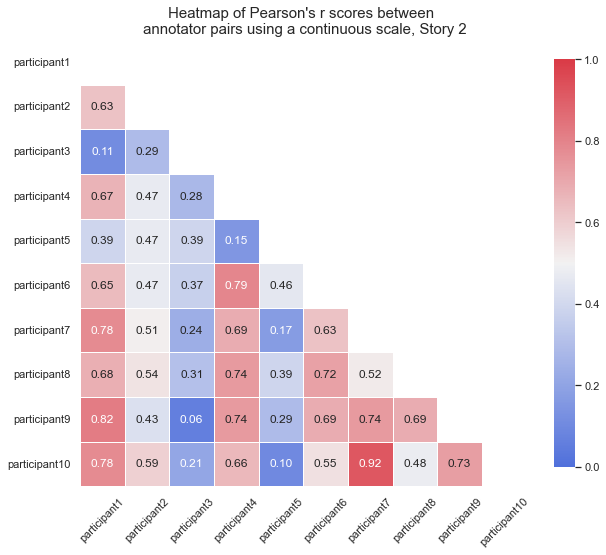

In [46]:
story2_annotators = ["participant1",
                     "participant2",
                     "participant3",
                     "participant4",
                     "participant5",
                     "participant6",
                     "participant7",
                     "participant8",
                     "participant9",
                     "participant10"]


heatmap_panel = create_heatmap_between_annotators_for_one_story(combinations_all_participants_story2, 
                                                          pearsons_values_story2,
                                                          story2_annotators,
                                                          "Heatmap of Pearson's r scores between \n annotator pairs using a continuous scale, Story 2")


In [47]:
# Data without low sgreement annotators


background_values_drop = background_values
del background_values_drop["participant3"]
del background_values_drop["participant5"]
background_values_drop



{'participant1': [2.57647920864627,
  3.97087378640777,
  1.0,
  1.2810038468584,
  2.67686389448617,
  1.36160468950357,
  1.0,
  1.0,
  1.72101117420773,
  1.55065030225316,
  1.9232460157538,
  1.0,
  2.45631067961165,
  4.4640043964096,
  3.59571350064114,
  1.98882579226965,
  3.94376259388166,
  3.35574281003847,
  3.23777248580326,
  3.36343652683642,
  5.0,
  4.01117420773035,
  1.75361787873237,
  1.74372595713501,
  4.45484520974537,
  3.99395493680161,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'participant2': [2.4954657873042,
  3.68326463314097,
  1.31690024732069,
  3.41450948062655,
  2.08161582852432,
  1.8161582852432,
  1.9078318219291,
  1.11376751854905,
  2.47139323990107,
  1.95993404781533,
  2.04204451772465,
  1.5444352844188,
  1.9477328936521,
  2.82918384171476,
  1.33338829348722,
  1.31986809563067,
  2.7714756801319,
  3.08936521022259,
  3.08112118713932,
  3.03759274525969,
  3.29282769991756,
  3.25292662819456,
  2.80511129431162,
  3.13388293487222,
  3.05

In [48]:


combinations_annotators_drop = get_combinations_of_annotators(background_values_drop)




corr = 0
not_corr = 0

pearsons_values = []
for participant_pair in combinations_annotators_drop:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    pearsons_value, p = get_pearsonsr(background_values_drop[ann1], background_values_drop[ann2])
    if p > 0.01:
        corr +=1
    if p < 0.01:
        not_corr +=1
    pearsons_values.append(pearsons_value)
    
print(pearsons_values)
print("correlated: ", corr)
print("not correlated: ", not_corr)
print(np.mean(pearsons_values))


Pearsons correlation coefficient: 0.631
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.674
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.651
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.782
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.681
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.815
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.775
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.467
Samples are correlated (reject H0) p=0.008
Pearsons correlation coefficient: 0.472
Samples are correlated (reject H0) p=0.007
Pearsons correlation coefficient: 0.514
Samples are correlated (reject H0) p=0.003
Pearsons correlation coefficient: 0.539
Samples are correlated (reject H0) p=0.002
Pearsons correlation coefficient: 0.433
Samples are uncorrelated (fail to reject H0) p=